# ABIDE subtype analysis
Follow the approach outlined in [Pierre's prevent_ad script](https://github.com/SIMEXP/Projects/blob/master/preventad/preventad_xp_2015_01_28b.m). In particular:

1. 

In [35]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin
from matplotlib.colors import LinearSegmentedColormap

In [36]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [37]:
def get_mask(mask_path):
    """
    Get the mask
    """
    m_img = nib.load(mask_path)
    mask = m_img.get_data()
    mask = mask!=0

    return mask, m_img

In [38]:
def prep_pheno(pheno_path, data_path, map_type, template):
    """
    Remove entries with duplicates or no imaging files
    """
    pheno = pd.read_csv(pheno_path)
    drop_id = list()
    path_list = list()
    pheno = pd.read_csv(pheno_path)
    for index, row in pheno.iterrows():
        s_id = row['SUB_ID']
        s_path = glob.glob(os.path.join(data_path, map_type, template.format(s_id, map_type)))
        if s_path:
            path_list.append(s_path[0])
        else:
            drop_id.append(index)
            continue
    clean_pheno = pheno.drop(drop_id)
    
    return clean_pheno, path_list

In [39]:
def get_files(paths, mask, net_id):
    """
    Get files from a list of paths and store the masked
    time series in an array and demean it
    """
    n_vox = np.sum(mask)
    n_files = len(path_list)
    # Prepare the storage matrix
    net_mat = np.zeros((n_vox, n_files))
    # Go through the files
    print('Grabbing network {}'.format(net_id+1))
    for index, s_path in enumerate(path_list):
        f_net = nib.load(s_path).get_data()[mask][..., net_id]
        net_mat[..., index] = f_net
    # Don't demean anything here, just return the array
    
    return net_mat

In [40]:
def make_corr(net_mat):
    """
    Build a subject by subject correlation matrix
    from the spatial maps and use hierarchical clustering
    to find a subtype partition
    """
    # Make a correlation matrix of the subjects
    corr_sub = np.corrcoef(net_mat, rowvar=0)
    link_sub = scl.hierarchy.linkage(corr_sub, method='ward')
    
    return (corr_sub, link_sub)

In [41]:
def make_part(link_sub, subtypes):
    """
    Partition subjects into groups based on
    hierarchical clustering linkage
    """
    part_sub = scl.hierarchy.fcluster(link_sub, subtypes, criterion='maxclust')
    
    return part_sub

In [42]:
def prep_glm(pheno, net_mat, part_sub):
    """
    Prepare a glm
    """
    n_vox = net_mat.shape[0]
    n_files = net_mat.shape[1]
    subtypes = len(np.unique(part_sub))
    # Make the average of the subtypes
    sbt_avg = np.zeros((n_vox, subtypes))
    for idx in range(subtypes):
        sub_id = np.unique(part_sub)[idx]
        # Zero mean, unit variance
        tmp_sbt_map = np.mean(net_mat[...,part_sub==sub_id],1)
        tmp_mean = np.mean(tmp_sbt_map)
        tmp_std = np.std(tmp_sbt_map)
        sbt_avg[..., idx] = (tmp_sbt_map - tmp_mean)/tmp_std
    
    # Generate the individual weights
    weights = np.zeros((n_files, subtypes))
    for s_id in range(subtypes):
        type_map = sbt_avg[:, s_id]
        weights[:, s_id] = np.array([np.corrcoef(type_map, net_mat[:,x])[0,1] for x in range(n_files)])
    
    # Generate the model matrix
    factors = ['DX_GROUP', 'AGE_AT_SCAN', 'FD_scrubbed']
    # Make dummy variables for the site factor
    site_factor = pd.get_dummies(pheno['SITE_ID'])
    # Turn the first site into the intercept
    site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
    site_factor['INTERCEPT'] = 1
    # Get the other variables
    other_factors = pheno.ix[:,factors]
    # Turn diagnosis into [0,1] vector
    other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
    # Demean age
    other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
    # Put them back together
    glm_pheno = pd.concat([site_factor, other_factors], axis=1)
    
    return (weights, glm_pheno, sbt_avg)

In [43]:
def visu_net(corr_sub, link_sub, val_range=[0,1], colm=cm.coolwarm):
    """
    Show the correlation map and the hierarchical clustering
    to get an idea of the data structure
    """
    f = plt.figure(figsize=(8,10))
    ax = f.add_subplot(111)
    subdend = bb.visu.add_subplot_axes(ax, [0, 0.71, 0.9, 0.29])
    submat = bb.visu.add_subplot_axes(ax, [0, 0, 0.9, 0.7])
    subcol = bb.visu.add_subplot_axes(ax, [0.91, 0, 0.09, 1])
    Z1 = scl.hierarchy.dendrogram(link_sub, ax=subdend, color_threshold=6)
    idx = Z1['leaves']
    tmp = corr_sub[idx, :]
    show_corr = tmp[:, idx]
    pc = submat.matshow(show_corr, aspect='auto',vmin=val_range[0], vmax=val_range[1], cmap=colm)
    plt.colorbar(pc, cax=subcol)
    subdend.set_xticklabels([])
    submat.set_xticklabels([])
    submat.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

In [44]:
def visu_weights(weights, part_sub, yrange=[0.3,1]):
    """
    Show the weights of each subtype
    """
    subtypes = len(np.unique(part_sub))
    # Show the weights by subtype
    fig = plt.figure(figsize=(12,3))
    gs = gridspec.GridSpec(1, subtypes, wspace=0.3)
    for i, stp in enumerate(np.unique(part_sub)):
        ax = fig.add_subplot(gs[0,i])
        ax.set_ylim(yrange)
        ax.set_xticklabels([])
        # Take a subsample of the data, fitting the current subtype
        stp_data = weights[part_sub==stp,:]
        tmp = ax.violinplot(stp_data)
        ax.set_title('subjects subtype {}'.format(i+1))

In [45]:
def visu_covar(clean_pheno, part_sub):
    """
    Show some covariates
    """
    # Do one more run, but look at motion
    fig = plt.figure(figsize=(12,3))
    gs = gridspec.GridSpec(1, 3, wspace=0.3)
    ages = [clean_pheno.loc[part_sub==stp]['AGE_AT_SCAN'].values for stp in np.unique(part_sub)]
    frames = [clean_pheno.loc[part_sub==stp]['frames_scrubbed '].values for stp in np.unique(part_sub)]
    motion = [clean_pheno.loc[part_sub==stp]['FD_scrubbed'].values for stp in np.unique(part_sub)]
    # Age
    ax_age = fig.add_subplot(gs[0,0])
    ax_age.set_xticklabels([])
    tmp = ax_age.violinplot(ages)
    ax_age.set_title('Age')
    # Age
    ax_frame = fig.add_subplot(gs[0,1])
    ax_frame.set_xticklabels([])
    tmp = ax_frame.violinplot(frames)
    ax_frame.set_title('Scrubbed Frames')
    # Age
    ax_motion = fig.add_subplot(gs[0,2])
    ax_motion.set_xticklabels([])
    tmp = ax_motion.violinplot(motion)
    ax_motion.set_title('Scrubbed FD')

In [73]:
def visu_subtype(subtype_map, mask_path, threshold=0.3, figsz=(10,8), colm=cm.spring):
    """
    Show the subtype maps
    """
    # Load the mask again to get the image
    mask, mask_image = get_mask(mask_path)
    # Get the subtypes out
    n_sbt = subtype_map.shape[1]
    # Prepare the figure
    fig = plt.figure(figsize=figsz)
    gs = gridspec.GridSpec(n_sbt, 1, hspace=0.3)
    for s_id in range(n_sbt):
        sbt_map = subtype_map[:, s_id]
        # Remap the map into volume space
        template = np.zeros_like(mask, dtype=np.float64)
        template[mask] = sbt_map
        # Make a nifti image out of the volume
        nifti_vol = nib.Nifti1Image(template, affine=mask_image.get_affine(), header=mask_image.get_header())
        # Visualize the thing with nilearn
        ax = fig.add_subplot(gs[s_id,0])
        nlp.plot_glass_brain(nifti_vol, title='subtype {}'.format(s_id+1),axes=ax, cmap=colm, threshold=threshold)

In [47]:
def run_glm(weights, glm_pheno, subtype=0):
    """
    Run the GLM
    """
    model = sm.OLS(weights[:,subtype], glm_pheno)
    results = model.fit()
    print(results.summary())
    return results

In [48]:
# Test a little bit
scale = 12
network_number = 2
net_id = network_number - 1
template = '*_fmri_{:07d}_session_1_run1_{}.nii.gz'
data_path = '/data1/abide/Out/Scores/sc{:02d}/time'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_3box_189_sample.csv'
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
map_types = ['stability_maps', 'rmap_part', 'dual_regression']
map_type = map_types[0]

In [49]:
mask, mask_img = get_mask(mask_path)
# Get nonduplicate paths
(clean_pheno, path_list) = prep_pheno(pheno_path, data_path, map_type, template)

In [50]:
tmp_mat = get_files(path_list, mask, net_id)
grand_average = np.reshape(np.mean(tmp_mat, 1), (tmp_mat.shape[0], 1))
net_mat = tmp_mat - grand_average

Grabbing network 2


In [51]:
# Define a new colormap
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25, 1.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
hotcold = LinearSegmentedColormap('hotcold', cdict)

See what happens to the subtypes with different kinds of 

In [52]:
# Build the correlation matrix
(corr_sub, link_sub) = make_corr(net_mat)

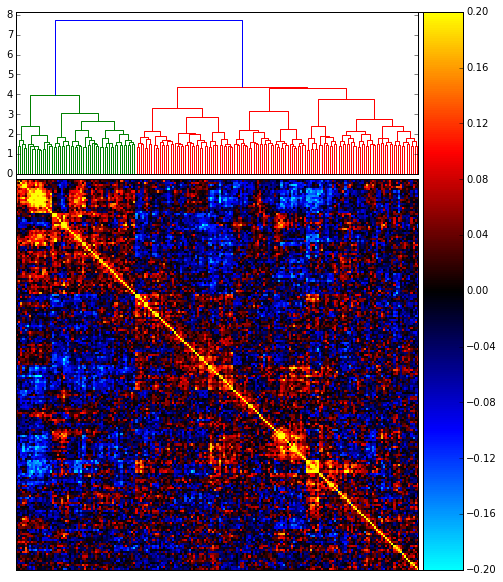

In [68]:
# Visualize the sample
visu_net(corr_sub, link_sub,val_range=[-0.2,0.2], colm=hotcold)

In [54]:
# Decide how many subtypes we want
subtypes = 4
part_sub = make_part(link_sub, subtypes)
# Get the weights and the GLM model matrix
(weights, glm_pheno, subtype_map) = prep_glm(clean_pheno, net_mat, part_sub)

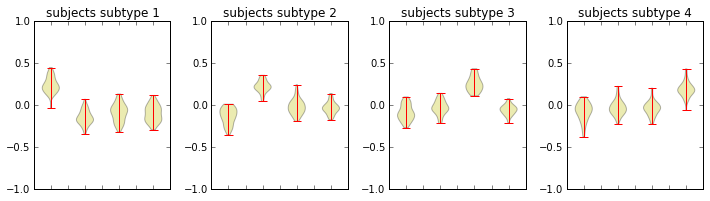

In [55]:
visu_weights(weights, part_sub,yrange=[-1,1])

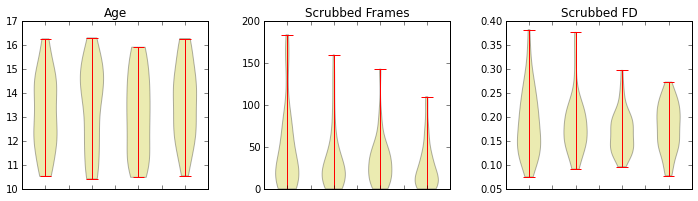

In [56]:
visu_covar(clean_pheno, part_sub)

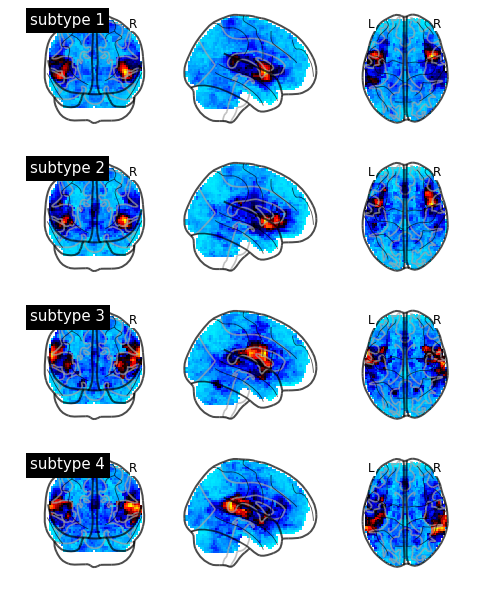

In [74]:
visu_subtype(subtype_map, mask_path, threshold=0, figsz=(8,10), colm=hotcold)

In [58]:
# Get the number of sites
n_sites = len(clean_pheno['SITE_ID'].unique())
# Prepare GLM contrasts
con_vec = np.zeros((2,glm_pheno.shape[1]))
# Diagnosis vs site
con_vec[0,1:n_sites] = 1
con_vec[0,n_sites] = -1*(n_sites-1)
# Diagnosis vs motion
con_vec[1,-1] = 1
con_vec[1,n_sites] = -1

In [59]:
con_vec

array([[ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -9.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.]])

In [60]:
# Run a GLM
glm_sbt1 = run_glm(weights, glm_pheno, subtype=0)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     11.54
Date:                Tue, 14 Jul 2015   Prob (F-statistic):           6.14e-17
Time:                        20:03:10   Log-Likelihood:                 104.34
No. Observations:                 189   AIC:                            -182.7
Df Residuals:                     176   BIC:                            -140.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.3272      0.059     -5.578      

In [61]:
# Post Hoc Tests
glm_sbt1.t_test(con_vec)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0             2.2227      0.420      5.291      0.000         1.394     3.052
c1             0.6499      0.210      3.101      0.002         0.236     1.063

In [62]:
glm_sbt2 = run_glm(weights, glm_pheno, subtype=1)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     7.369
Date:                Tue, 14 Jul 2015   Prob (F-statistic):           6.74e-11
Time:                        20:03:11   Log-Likelihood:                 115.47
No. Observations:                 189   AIC:                            -204.9
Df Residuals:                     176   BIC:                            -162.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.1096      0.055      1.982      

In [63]:
# Post Hoc Tests
glm_sbt2.t_test(con_vec)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0            -0.8097      0.396     -2.044      0.042        -1.591    -0.028
c1             0.0602      0.198      0.305      0.761        -0.330     0.450

In [64]:
glm_sbt3 = run_glm(weights, glm_pheno, subtype=2)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     2.529
Date:                Tue, 14 Jul 2015   Prob (F-statistic):            0.00425
Time:                        20:03:11   Log-Likelihood:                 101.32
No. Observations:                 189   AIC:                            -176.6
Df Residuals:                     176   BIC:                            -134.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.1342      0.060      2.252      

In [65]:
# Post Hoc Tests
glm_sbt3.t_test(con_vec)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0             0.0695      0.427      0.163      0.871        -0.773     0.912
c1            -0.5555      0.213     -2.608      0.010        -0.976    -0.135

In [66]:
glm_sbt4 = run_glm(weights, glm_pheno, subtype=3)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     5.987
Date:                Tue, 14 Jul 2015   Prob (F-statistic):           1.02e-08
Time:                        20:03:11   Log-Likelihood:                 131.08
No. Observations:                 189   AIC:                            -236.2
Df Residuals:                     176   BIC:                            -194.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.2313      0.051      4.542      

In [67]:
# Post Hoc Tests
glm_sbt4.t_test(con_vec)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0            -2.3658      0.365     -6.488      0.000        -3.085    -1.646
c1            -0.5149      0.182     -2.830      0.005        -0.874    -0.156

In [71]:
glm_sbt4.pvalues['DX_GROUP']

0.00081524726432861971

In [72]:
subtype_map.shape

(45309, 4)